In [10]:
# 必要なパッケージを呼び出す
using Printf
using Roots
using Interpolations
using Plots
using NLsolve

In [11]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
struct Model{TI<:Integer, TF<:AbstractFloat}

    # カリブレーション
    beta::TF            # 割引因子
    gamma::TF           # 相対的危険回避度(異時点間の代替の弾力性の逆数)
    alpha::TF           # 資本分配率
    delta::TF           # 固定資本減耗(delta=1.0のときは解析解が存在)  

    # 定常状態の値
    ykss::TF
    kss::TF
    yss::TF
    css::TF    
    
    # EGM
    kmax::TF            # 資本グリッドの最大値
    kmin::TF            # 資本グリッドの最小値
    nk::TI              # グリッドの数
    kpgrid::Array{TF,1} # 資本グリッド(kではなく、k'についてグリッドをとる)
    wpgrid::Array{TF,1} # 富のグリッド(Carrol(2006)の手法)

    # 時間反復法に関するパラメータ
    maxiter::TI         # 繰り返し計算の最大値
    tol::TF             # 許容誤差

end

In [12]:
function mu_CRRA(cons,gamma)
    """
    --------------------------
    === CRRA型限界効用関数 ===
    --------------------------
    <inputs>
    ・cons: 消費量
    ・gamma: 相対的リスク回避度(異時点間の代替弾力性の逆数)
    <output>
    ・consとgamma の下での限界効用水準
    """

    mu = cons.^(-gamma)

    return mu
end

mu_CRRA (generic function with 1 method)

In [13]:
function f(m,x,wealth)
    """
    -------------------------------------------------------------
    === 予算制約式の残差を求める関数(=0になるようなcapitalを選ぶ) ===
    -------------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・x: 今期の資本保有量 (nlsolveの利用上ベクトル表記する)
    ・wealth: 今期の資産保有量
    <output>
    ・res: 
    """
    capital = x[1]; 
    res = (capital.^m.alpha) + (1-m.delta)*capital - wealth;

    return res
end

f (generic function with 1 method)

In [14]:
# メインファイル

# カリブレーション
beta = 0.96;  # 割引因子
gamma = 1.0;  # 相対的リスク回避度(異時点間の代替の弾力性の逆数)
alpha = 0.40; # 資本分配率
delta = 1.0;  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha;
kss = ykss^(1.0/(alpha-1.0));
yss = ykss*kss;
css = yss-delta*kss;

# EGM
kmax = 2.0*kss;   # 資本グリッドの最大値
kmin = 0.1*kss;  # 資本グリッドの最小値(0にすると生産が出来なくなる)

# STEP 1(a): グリッド生成 
nk = 101;      # グリッドの数
kpgrid = collect(range(kmin,kmax,length=nk));

# Carrol's (2005) change of variables
# cを求めた後、資源制約式をkについて解く必要がない
wpgrid = kpgrid.^alpha + (1-delta)*kpgrid;

# 時間反復法に関するパラメータ
maxiter = 1000; # 繰り返し計算の最大値
tol = 1e-8;     # 許容誤差(STEP 2)

### EGMによる時間反復法 
(MATLAB の main_ti_egm.m に対応)

In [25]:
# 収束の基準に関するパラメータ
it = 1;         # ループ・カウンター
dif2 = 1.0;     # 政策関数の繰り返し誤差
tolfun = 1e-10; # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kpgrid,wpgrid,maxiter,tol);

println("-+- Solve a neoclassical growth model with time iteration -+-")
println(" ")

# STEP 1(b): 政策関数の初期値を当て推量
# ここでの政策関数はc'=htilde(w')となる
cfcn0 = copy(m.kpgrid);
cfcn1 = zeros(m.nk);

# 繰り返し誤差を保存する変数を設定 
dif = zeros(2,m.maxiter);

# 計算されたc,kを保存
cgrid = zeros(m.nk);
kgrid = zeros(m.nk);

# STEP 4: 政策関数を繰り返し計算
@time while (it < m.maxiter) && (dif2 > tol)

    for i in 1:m.nk

        kprime = m.kpgrid[i];
        cnext = cfcn0[i]; # c'=h(k'): kprimeにおけるcnextの値
        uc = m.beta*mu_CRRA(cnext,m.gamma)*(m.alpha*kprime^(m.alpha-1)+(1-m.delta));
        cons = uc^(-1/m.gamma); # % mu_CRRAの逆関数
        
        # c + k' = k^alpha + (1-delta)*kをkについて解く
        #res = nlsolve(x-> f(m,x,kprime+cons),[(cons+kprime)^(1/m.alpha)],ftol=tolfun);
        res = nlsolve(x-> f(m,x,kprime+cons),[kprime],ftol=tolfun,method=:trust_region);
        capital = res.zero[1];
        #capital = find_zero(x-> f(m,x,kprime+cons),(0.0,10.0))

        # 計算されたc,kを保存
        cgrid[i] = cons;
        kgrid[i] = capital;

    end

    # 計算されたc,kから、c'=h(k')をアップデートする
    interp_c = LinearInterpolation(kgrid,cgrid,extrapolation_bc=Line());
    cfcn1 .= interp_c.(m.kpgrid);

    # 繰り返し計算誤差を確認
    dif2 = maximum(abs.(cfcn1-cfcn0));

    # 収束途中の繰り返し計算誤差を保存
    dif[2,it] = copy(dif2);
    
    # 政策関数をアップデート
    cfcn0 = copy(cfcn1);

    @printf "iteration index: %1d \n" it  
    @printf "policy function iteration error: %1.6f \n" dif2 
    flush(stdout)

    it += 1
    
end

-+- Solve a neoclassical growth model with time iteration -+-
 


LoadError: DomainError with -6.0554544523933395e-6:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [21]:
kgrid = copy(kpgrid); # c'=h(k') は c=h(k)と同じ

# 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = kgrid.^m.alpha + (1-m.delta)*kgrid - cfcn0;

In [22]:
# 解析的解
p_true = m.beta*m.alpha*(kgrid.^m.alpha);

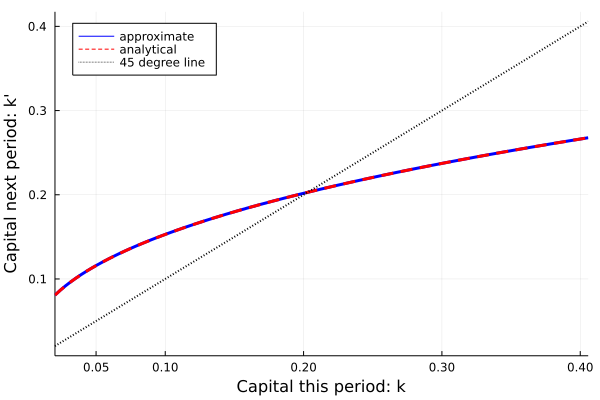

In [23]:
plot(kgrid,pfcn0,c=:blue,lw=3,label="approximate",legend=:topleft)
plot!(kgrid,p_true,c=:red,ls=:dash,lw=3,label="analytical")
plot!(kgrid,kgrid,c=:black,ls=:dot,lw=2,label="45 degree line")
xlabel!("Capital this period: k")
ylabel!("Capital next period: k'")
xlims!(m.kmin,m.kmax)
xticks!([0.05,0.1,0.2,0.3,0.4,0.5])


### Carroll(2006)のEGMによる時間反復法
 (MATLAB の main_ti_eg_cov_.m に対応)

In [10]:
# 収束の基準に関するパラメータ
it = 1;         # ループ・カウンター
dif2 = 1.0;     # 政策関数の繰り返し誤差
tolfun = 1e-10; # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kpgrid,wpgrid,maxiter,tol);

println("-+- Solve a neoclassical growth model with time iteration -+-")
println(" ")

# STEP 1(b): 政策関数の初期値を当て推量
# ここでの政策関数はc'=htilde(w')となる
cfcn0 = copy(m.kpgrid);
cfcn1 = zeros(m.nk);

# 繰り返し誤差を保存する変数を設定 
dif = zeros(2,m.maxiter);

# 計算されたc,kを保存
cgrid = zeros(m.nk);
wgrid = zeros(m.nk);

# STEP 4: 政策関数を繰り返し計算
@time while (it < m.maxiter) && (dif2 > tol)

    for i in 1:m.nk

        kprime = m.kpgrid[i];
        wprime = m.wpgrid[i];
        cnext = cfcn0[i]; # c'=h(w'): wprimeにおけるcnextの値
        uc = m.beta*mu_CRRA(cnext,m.gamma)*(m.alpha*kprime^(m.alpha-1)+(1-m.delta));
        cons = uc^(-1/m.gamma); # % mu_CRRAの逆関数

        # w = c+k' (非線形方程式を解く必要がない)
        wealth = cons + kprime;
        
        # 計算されたc,wを保存
        cgrid[i] = cons;
        wgrid[i] = wealth;

    end

    # 計算されたc,wから、c'=htilde(w')をアップデートする
    interp_c = LinearInterpolation(wgrid,cgrid,extrapolation_bc=Line());
    cfcn1 .= interp_c.(m.wpgrid);

    # 繰り返し計算誤差を確認
    dif2 = maximum(abs.(cfcn1-cfcn0));

    # 収束途中の繰り返し計算誤差を保存
    dif[2,it] = copy(dif2);
    
    # 政策関数をアップデート
    cfcn0 = copy(cfcn1);

    @printf "iteration index: %1d \n" it  
    @printf "policy function iteration error: %1.6f \n" dif2 
    flush(stdout)

    it += 1
    
end

-+- Solve a neoclassical growth model with time iteration -+-
 
iteration index: 1 
policy function iteration error: 0.098226 
iteration index: 2 
policy function iteration error: 0.031738 
iteration index: 3 
policy function iteration error: 0.011346 
iteration index: 4 
policy function iteration error: 0.005241 
iteration index: 5 
policy function iteration error: 0.002166 
iteration index: 6 
policy function iteration error: 0.000857 
iteration index: 7 
policy function iteration error: 0.000333 
iteration index: 8 
policy function iteration error: 0.000128 
iteration index: 9 
policy function iteration error: 0.000049 
iteration index: 10 
policy function iteration error: 0.000019 
iteration index: 11 
policy function iteration error: 0.000007 
iteration index: 12 
policy function iteration error: 0.000003 
iteration index: 13 
policy function iteration error: 0.000001 
iteration index: 14 
policy function iteration error: 0.000000 
iteration index: 15 
policy function iteration er

In [11]:
# c'=h(k') は c=h(k)と同じ
kgrid = kpgrid; 

# 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = kgrid.^alpha + (1-delta)*kgrid - cfcn0;

In [12]:
# 解析的解
p_true = beta*alpha*(kgrid.^alpha);

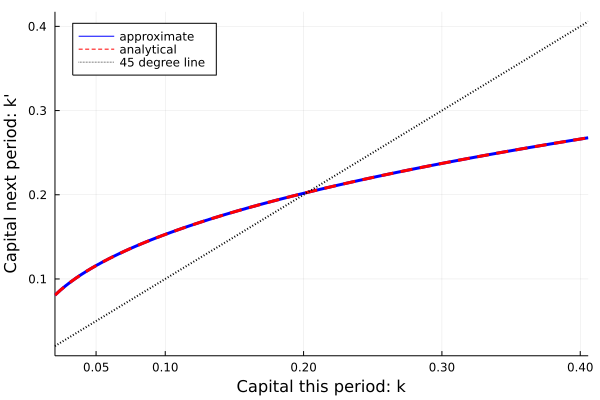

In [13]:
plot(kgrid,pfcn0,c=:blue,lw=3,label="approximate",legend=:topleft)
plot!(kgrid,p_true,c=:red,ls=:dash,lw=3,label="analytical")
plot!(kgrid,kgrid,c=:black,ls=:dot,lw=2,label="45 degree line")
xlabel!("Capital this period: k")
ylabel!("Capital next period: k'")
xlims!(m.kmin,m.kmax)
xticks!([0.05,0.1,0.2,0.3,0.4,0.5])